In [20]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../src/mythicwind/')

from csv_io import read_frame
from postprocess import *
from ellipse import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import integrate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### read in data

In [5]:
data = read_frame('../tests/turbines/turbine-99/helihoist-1/tom/clean/turbine-12_helihoist-1_tom_2019-11-05-00-16-25_2019-11-05-00-50-29_0005.csv')
# data = data['2019-11-04 22:50 +00:00' : '2019-11-04 23:15 +00:00']

### time index delta T

<IPython.core.display.Javascript object>


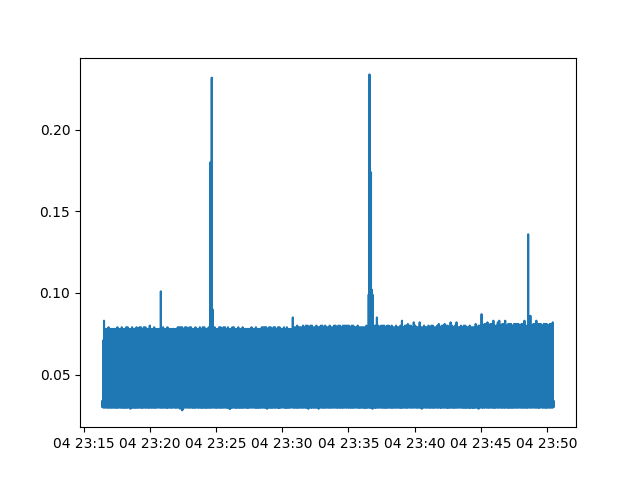

<IPython.core.display.Javascript object>


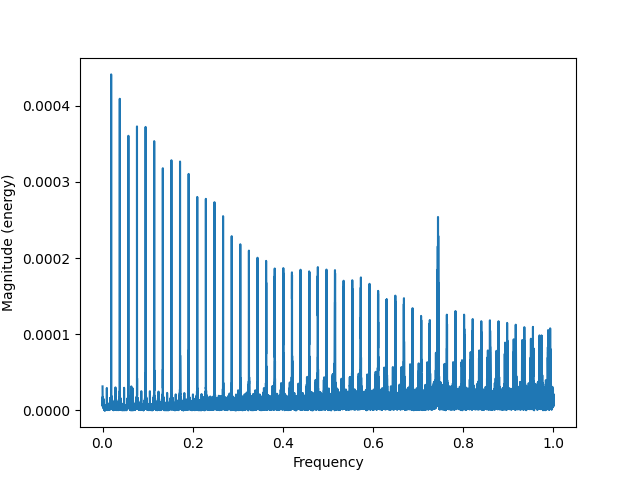

In [7]:
deltaT = data.index.to_series().diff()
deltaT = deltaT/pd.to_timedelta(1, unit='S')
plt.figure()
plt.plot(deltaT)
deltaT_np = deltaT.to_numpy()
deltaT_np = deltaT_np[1:]
plt.figure()
spec = plt.magnitude_spectrum(deltaT_np - np.mean(deltaT_np))

### resample data

In [8]:
data_r = resample_acceleration(data)

<IPython.core.display.Javascript object>


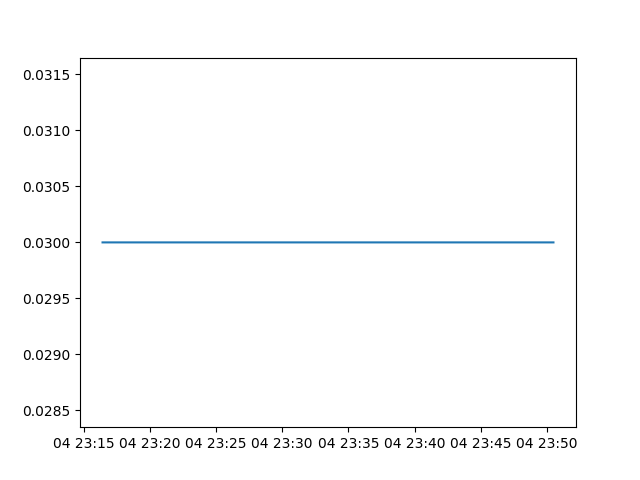

<IPython.core.display.Javascript object>


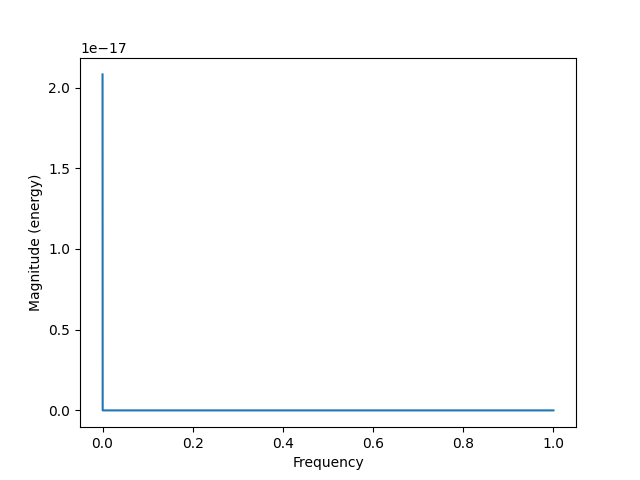

In [9]:
deltaT = data_r.index.to_series().diff()
deltaT = deltaT/pd.to_timedelta(1, unit='S')
plt.figure()
plt.plot(deltaT)
deltaT_np = deltaT.to_numpy()
deltaT_np = deltaT_np[1:]
plt.figure()
spec = plt.magnitude_spectrum(deltaT_np - np.mean(deltaT_np))

---

### new integraion approach

In [22]:
@njit(fastmath=True, cache=True)
def butter_highpass_sosfiltfilt_numba(data, lowcut, fs, pad='even', padlen=5000, order=3):
    """
    applies a symmetric filter (no phase offset)
    """

    if pad not in ('even', 'odd', 'constant', None):
        raise Exception ('please provide a valid padding')

    nyq = fs*0.5
    low = lowcut/nyq

    sos = butter(order, low, btype='highpass', output='sos')
    y = sosfiltfilt(sos, data, padtype=pad, padlen=padlen)

    return y

def butter_highpass_sosfiltfilt(data, lowcut, fs, pad='even', padlen=5000, order=3):
    """
    applies a symmetric filter (no phase offset)
    """

    if pad not in ('even', 'odd', 'constant', None):
        raise Exception ('please provide a valid padding')

    nyq = fs*0.5
    low = lowcut/nyq

    sos = butter(order, low, btype='highpass', output='sos')
    y = sosfiltfilt(sos, data, padtype=pad, padlen=padlen)

    return y

In [ ]:
x = data_r.acc_x.to_numpy()
t = data_r.index.astype('int64')/1e9
t -= t[0]

In [23]:
%timeit x_f = butter_highpass_sosfiltfilt(x, lowcut=0.1, fs=33.3333)

1.95 ms ± 48.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<IPython.core.display.Javascript object>


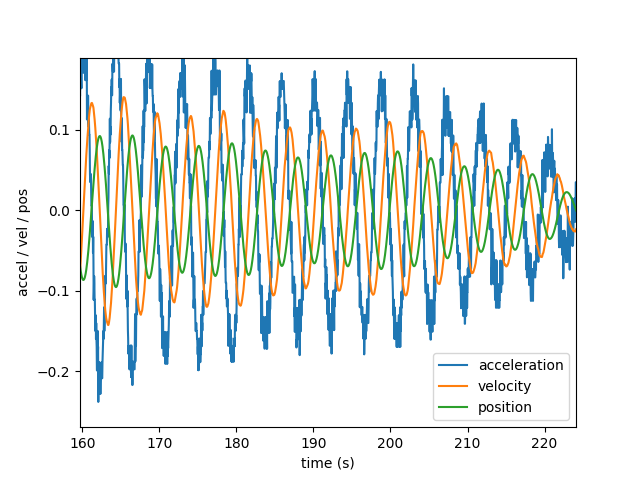

In [11]:
x_f = butter_highpass_sosfiltfilt(x, lowcut=0.1, fs=33.3333)

v = integrate.cumtrapz(x_f, t, initial=0)
v_f = butter_highpass_sosfiltfilt(v, lowcut=0.1, fs=33.3333)

p = integrate.cumtrapz(v_f, t, initial=0)
p_f = butter_highpass_sosfiltfilt(p, lowcut=0.1, fs=33.3333)

plt.figure()
#plt.plot(t, x)
plt.plot(t, x_f, label='acceleration')
#plt.plot(t, v)
plt.plot(t, v_f, label='velocity')
#plt.plot(t, p)
plt.plot(t, p_f, label='position')
plt.xlabel('time (s)')
plt.ylabel('accel / vel / pos')
plt.legend()
plt.savefig('new_integration.png', dpi=300)

In [17]:
%timeit avp_n = filter_integrate(data_r)

32.9 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


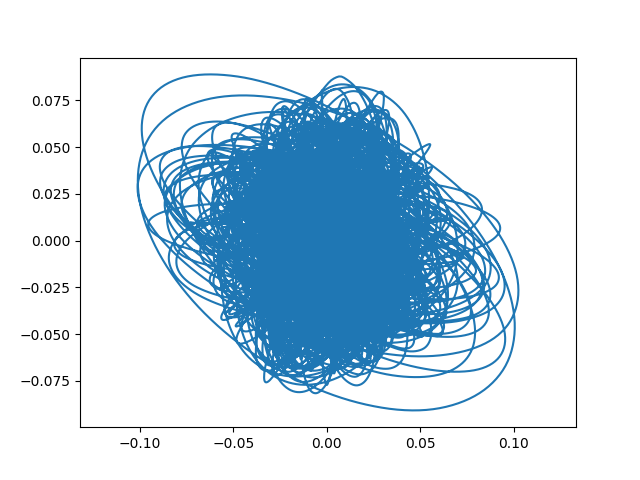

(-0.11134037553822206,
 0.1127510390342018,
 -0.09984785158000097,
 0.0978650617643219)

In [15]:
plt.figure()
plt.plot(avp_n.pos_x, avp_n.pos_z)
plt.axis('equal')

2019-11-04 23:15:00+00:00
omitting last element


<IPython.core.display.Javascript object>


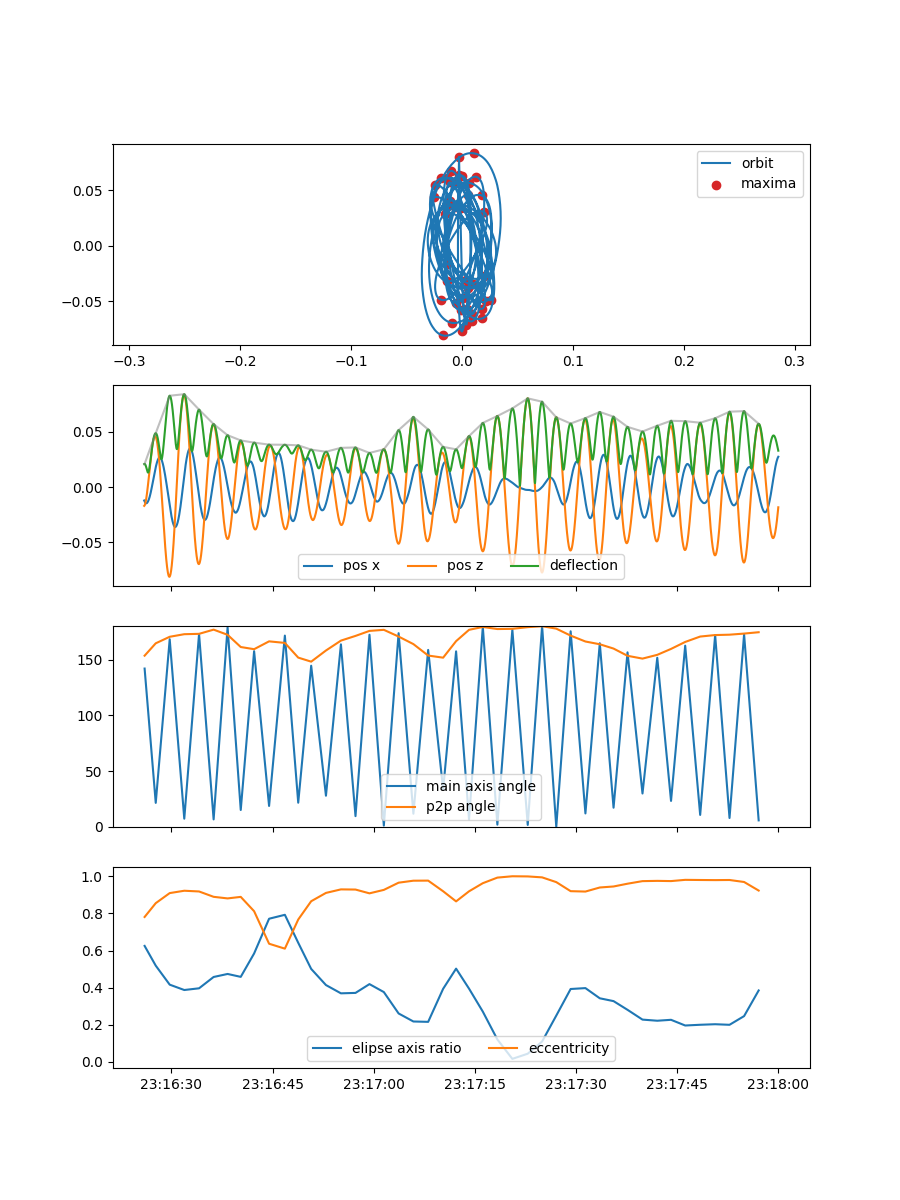

2019-11-04 23:18:00+00:00
omitting last element
min index comes first, removing


<IPython.core.display.Javascript object>


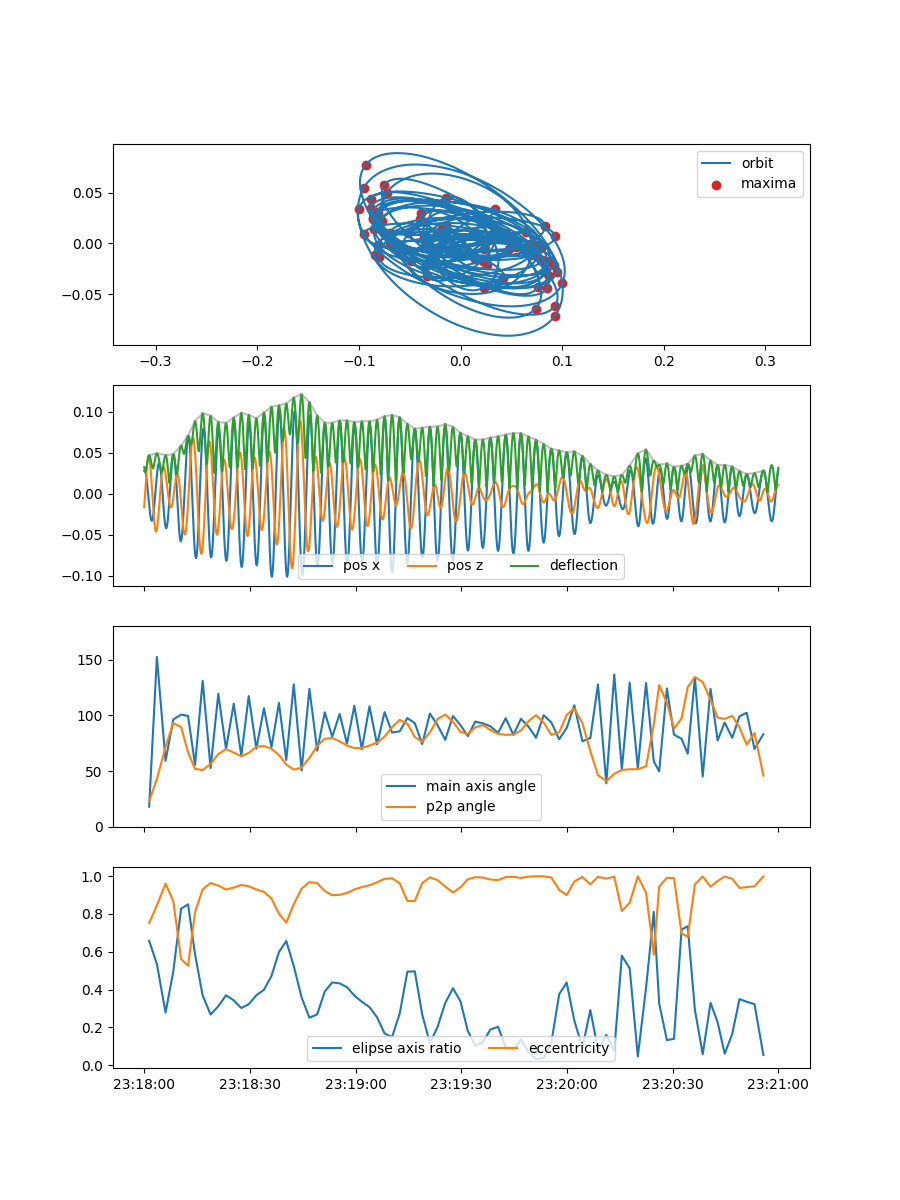

2019-11-04 23:21:00+00:00
omitting last element


<IPython.core.display.Javascript object>


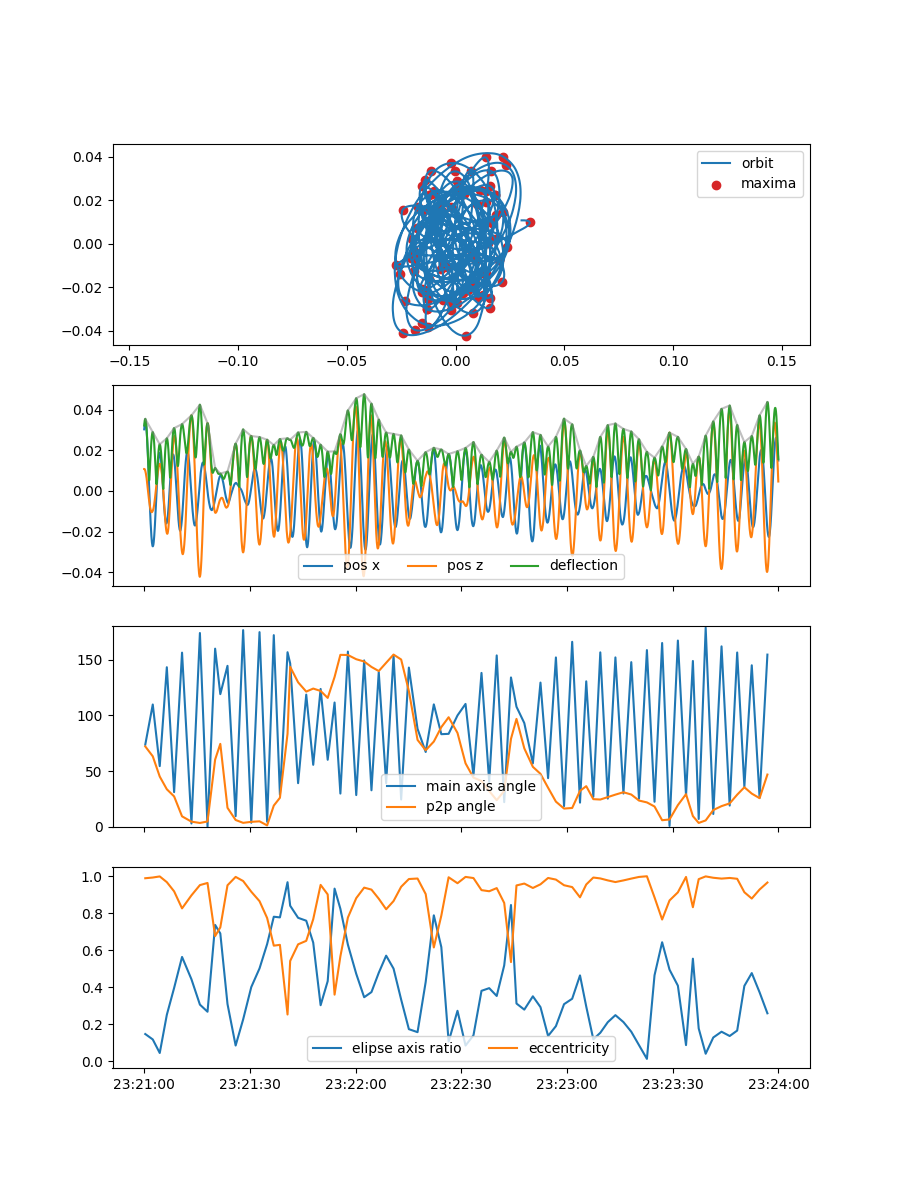

2019-11-04 23:24:00+00:00
omitting last element
min index comes first, removing


<IPython.core.display.Javascript object>


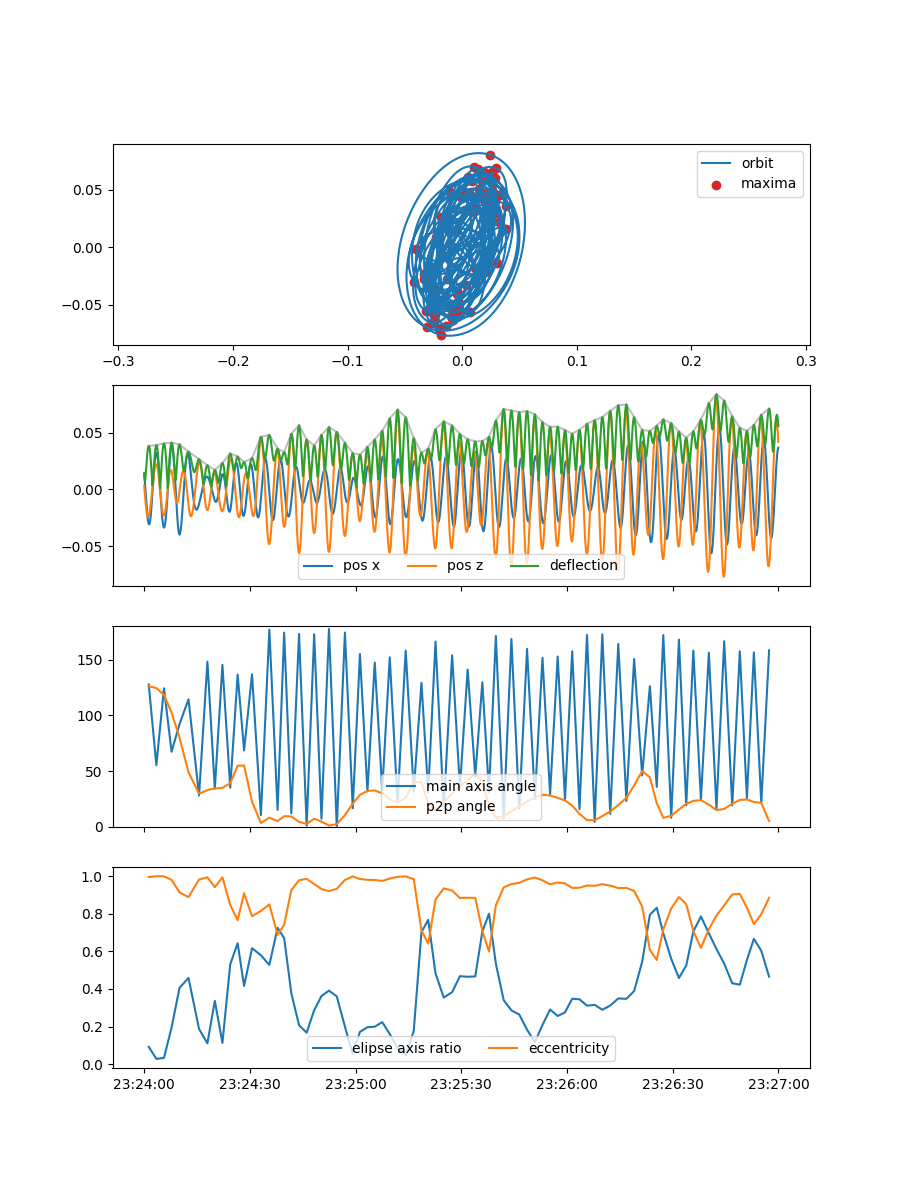

2019-11-04 23:27:00+00:00
omitting last element
min index comes first, removing


<IPython.core.display.Javascript object>


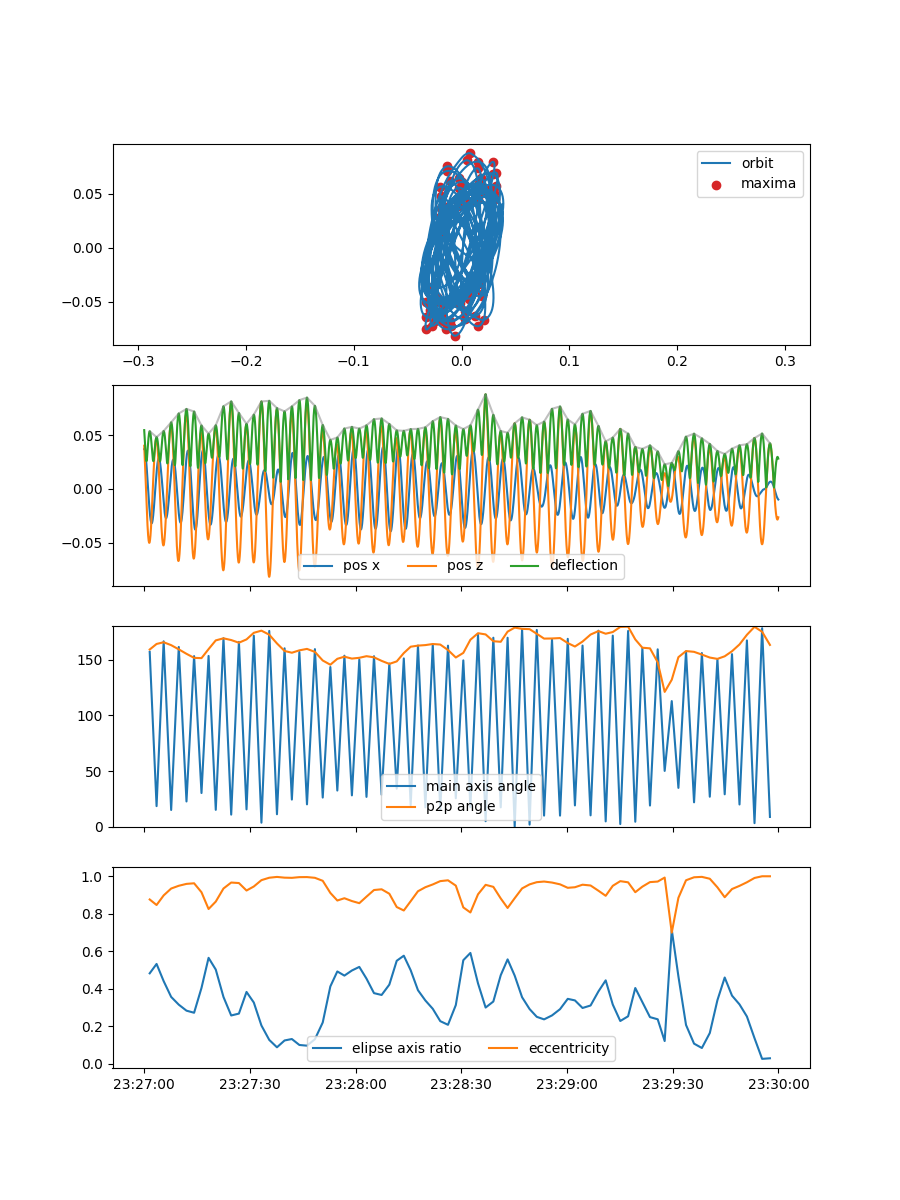

2019-11-04 23:30:00+00:00
omitting last element
min index comes first, removing


<IPython.core.display.Javascript object>


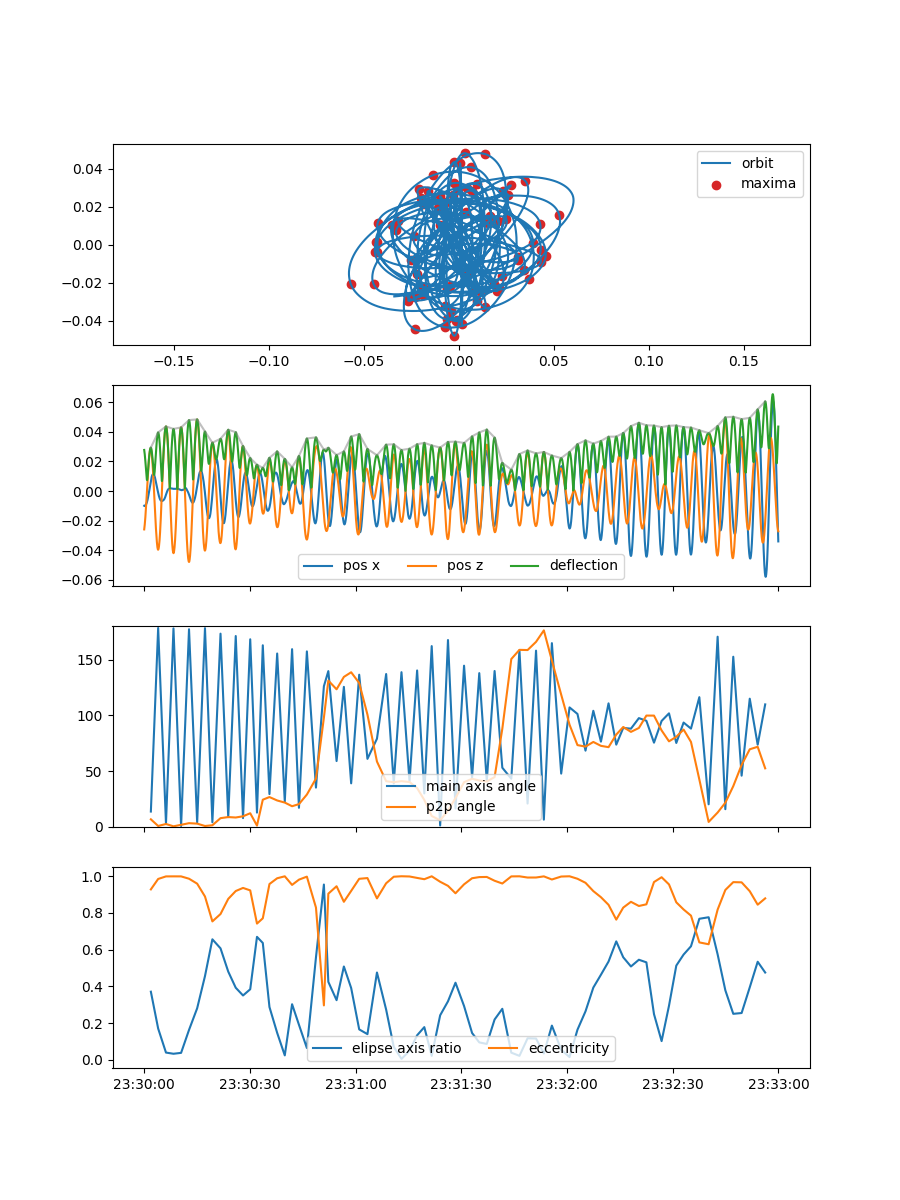

2019-11-04 23:33:00+00:00


<IPython.core.display.Javascript object>


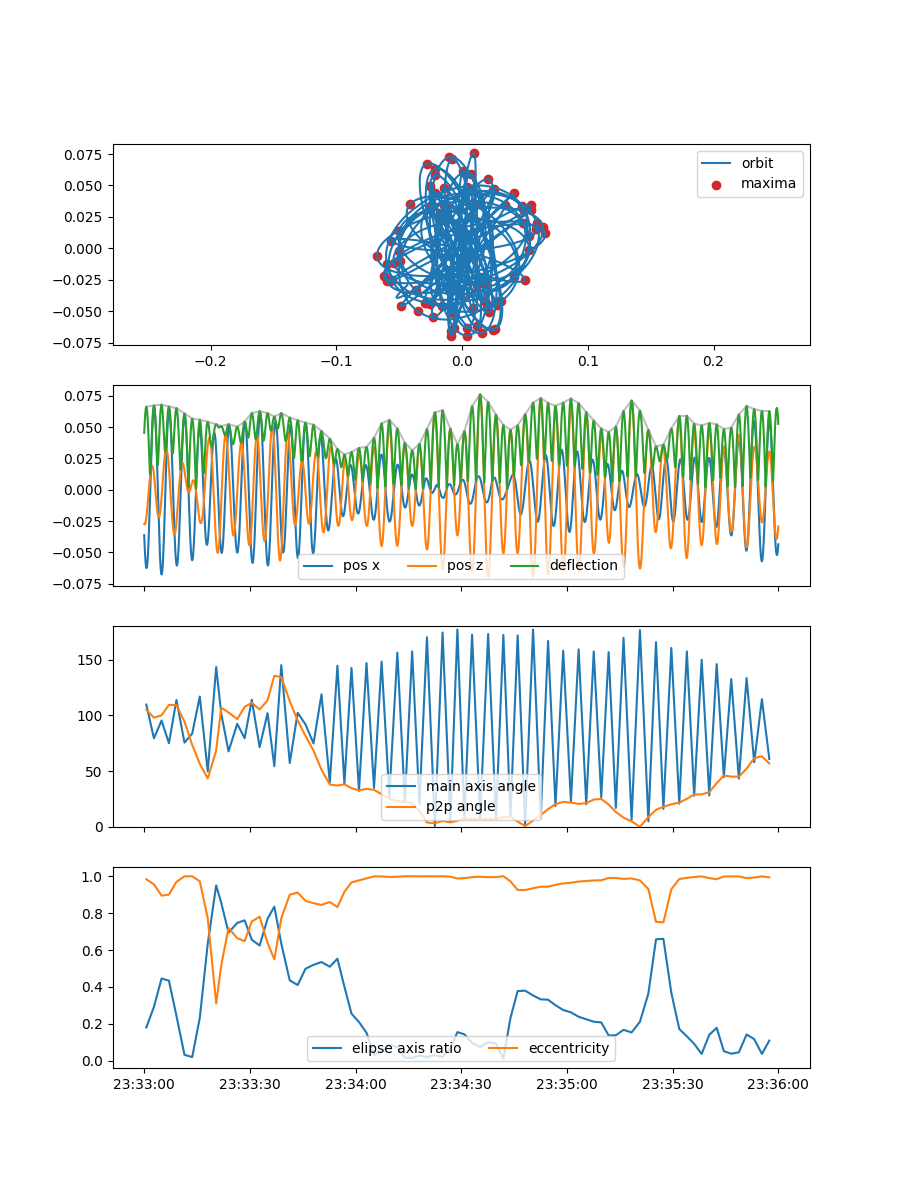

2019-11-04 23:36:00+00:00
omitting last element
min index comes first, removing


<IPython.core.display.Javascript object>


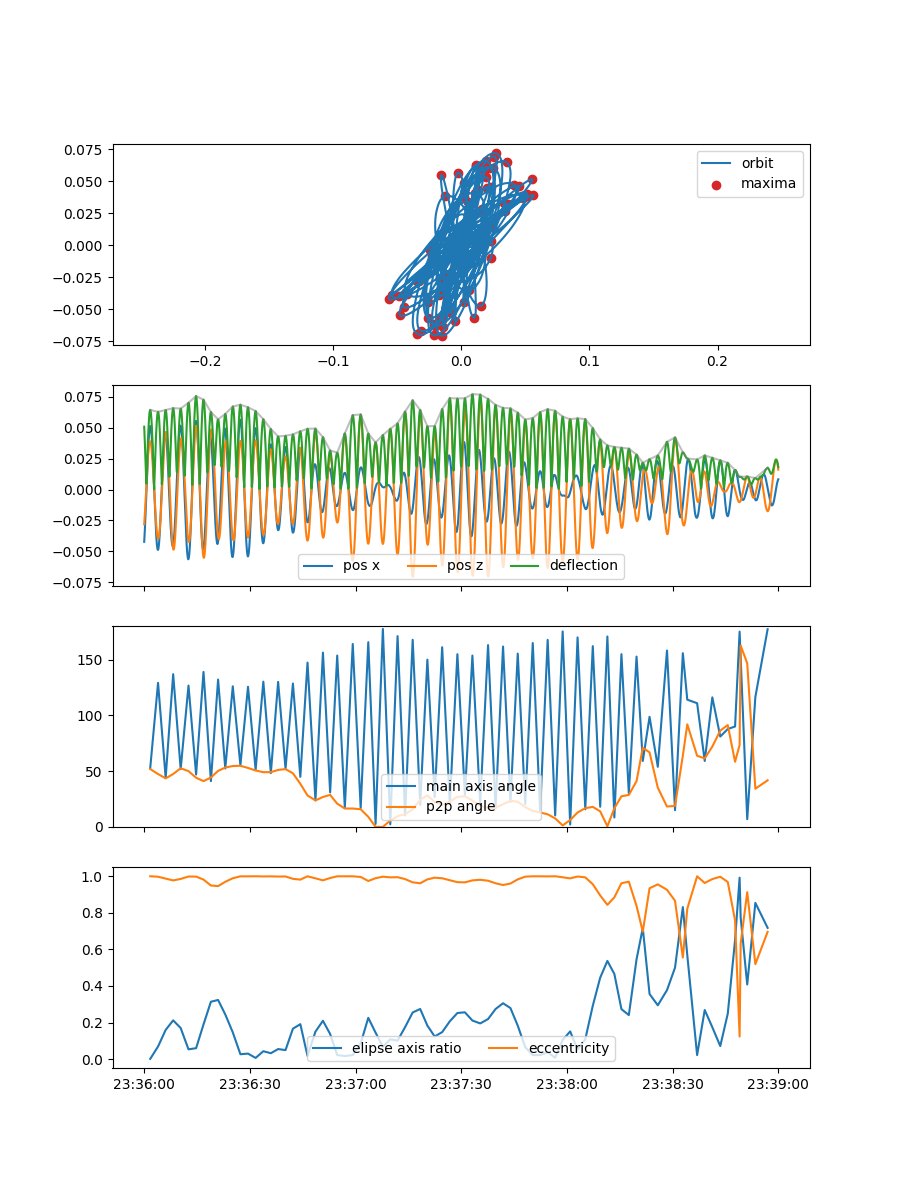

2019-11-04 23:39:00+00:00
min index comes first, removing


<IPython.core.display.Javascript object>


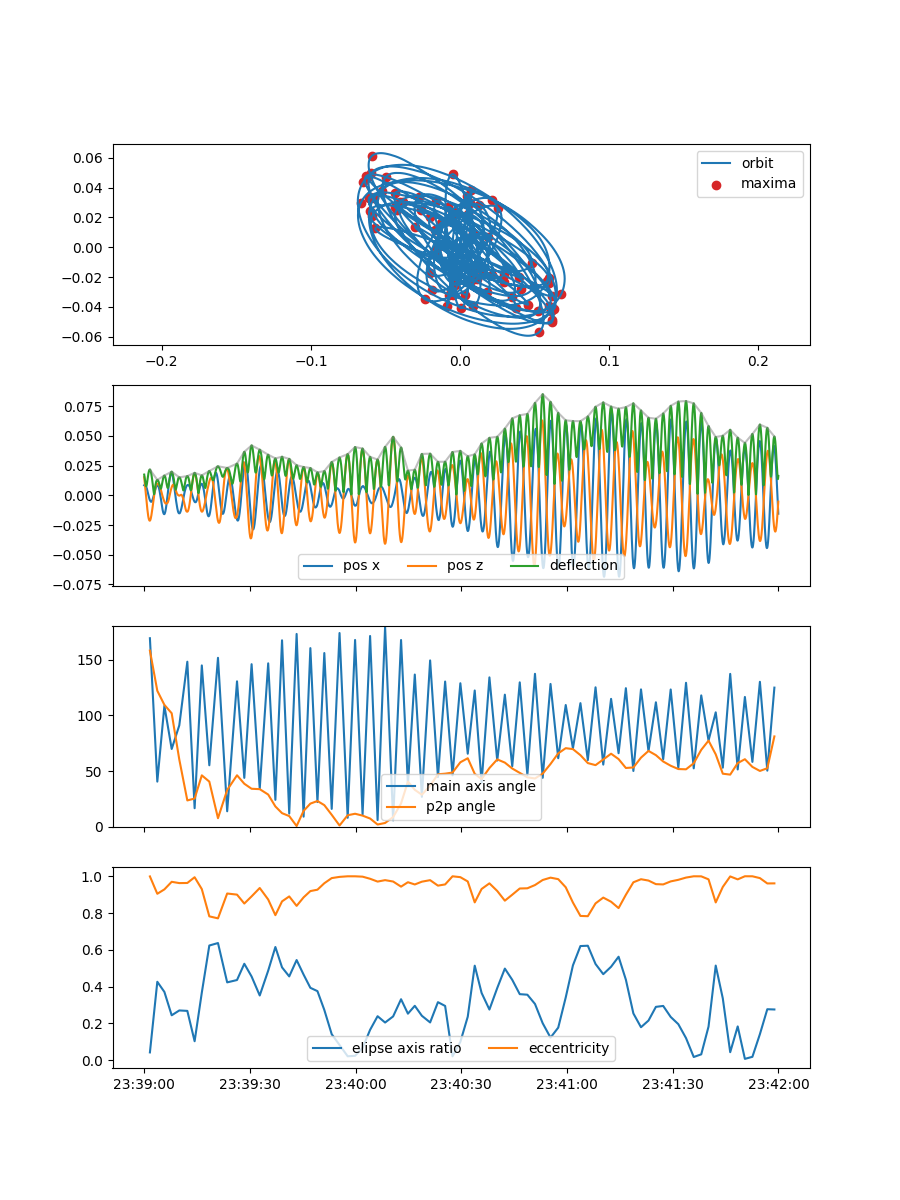

2019-11-04 23:42:00+00:00
omitting last element


<IPython.core.display.Javascript object>


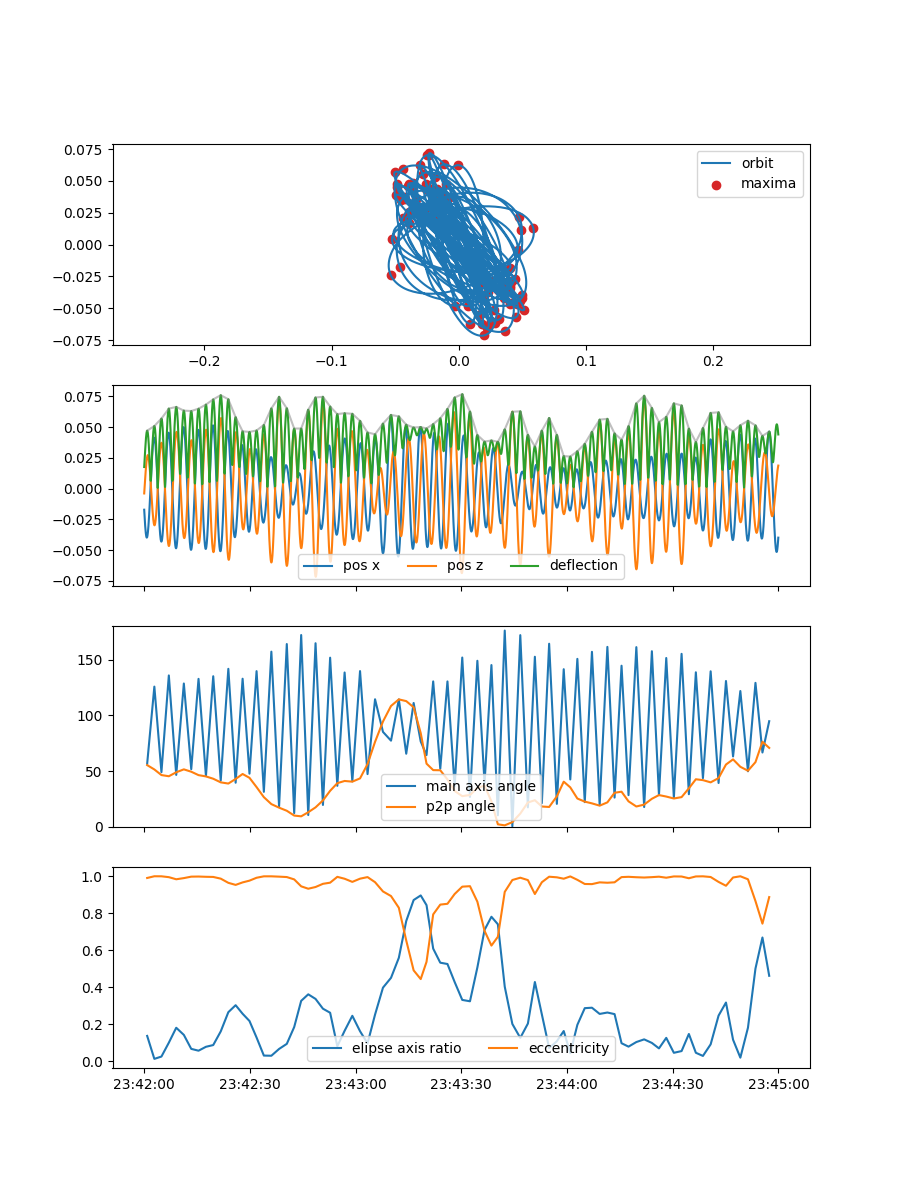

2019-11-04 23:45:00+00:00
min index comes first, removing


<IPython.core.display.Javascript object>


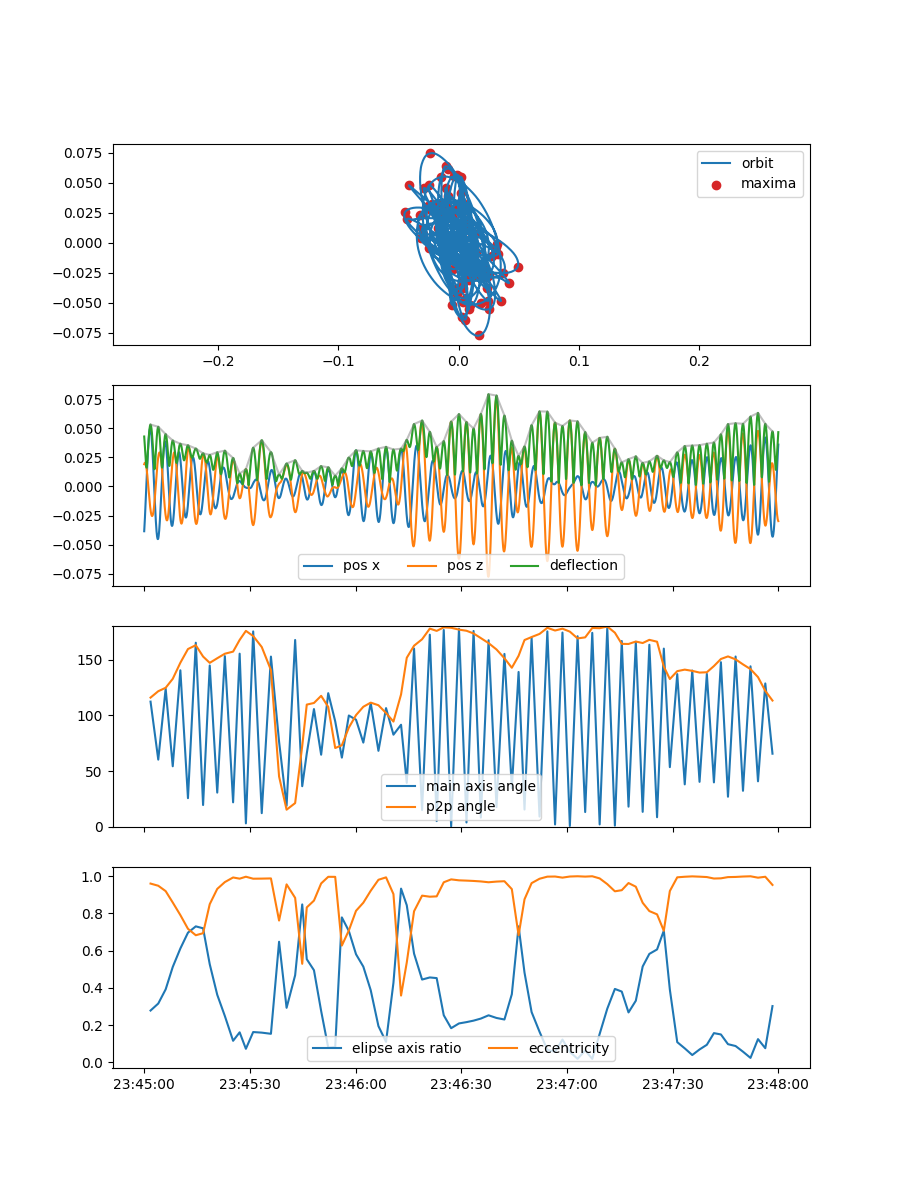

2019-11-04 23:48:00+00:00


<IPython.core.display.Javascript object>


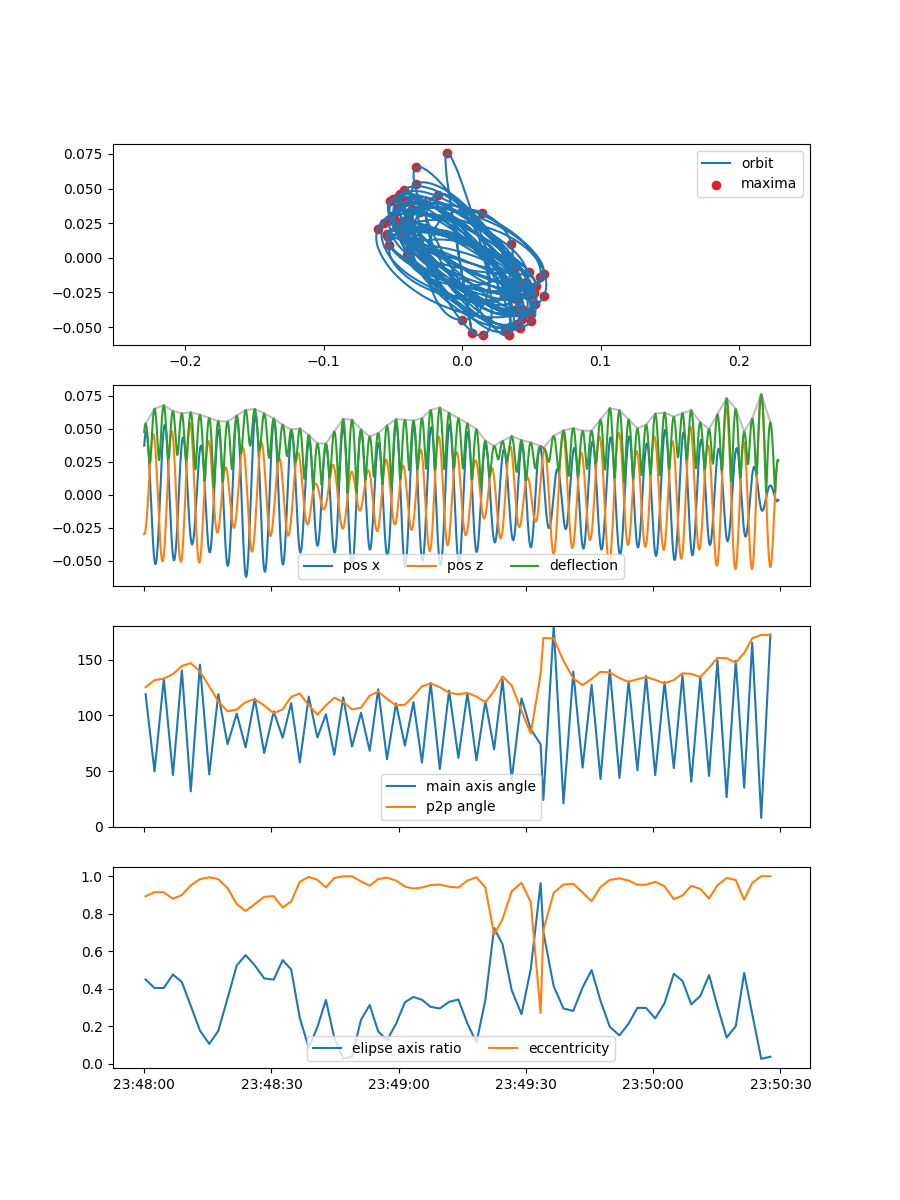

In [16]:
for t, d in avp_n.resample('3min'):
    print(t)
    geometry_df = geometry_analysis(d)
    plot_geometry_analysis(d, geometry_df)